In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
def sin(x, T=100):
    return np.sin(2.0 * np.pi * x / T)

def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2 * T + 1)
    noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))
    return sin(x) + noise

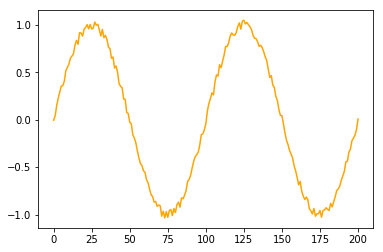

In [3]:
T = 100
f = toy_problem(T)
plt.plot(f, color='orange')
plt.show()

In [4]:
length_of_sequences = 2 * T  # 全時系列の長さ
maxlen = 25  # １つの時系列の長さ

data = []
target = []

for i in range(0, length_of_sequences - maxlen + 1):
    data.append(f[i: i + maxlen])
    target.append(f[i + maxlen])

In [5]:
X = np.array(data).reshape(len(data), maxlen, 1)
Y = np.array(target).reshape(len(data), 1)

In [6]:
N_train = int(len(data) * 0.9)
N_validation = len(data) - N_train

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=N_validation)

# TensorFlowによる実装

In [7]:
def inference(x, n_batch, maxlen=None, n_hidden=None, n_out=None):
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.01)
        return tf.Variable(initial)
    
    def bias_variable(shape):
        initial = tf.zeros(shape, dtype=tf.float32)
        return tf.Variable(initial)
    
    cell = tf.contrib.rnn.GRUCell(n_hidden)
    initial_state = cell.zero_state(n_batch, tf.float32)
    state = initial_state
    outputs = []  # 過去の隠れ層の出力を保存
    with tf.variable_scope('RNN'):
        for t in range(maxlen):
            if t > 0:
                tf.get_variable_scope().reuse_variables()
            (cell_output, state) = cell(x[:, t, :], state)
            outputs.append(cell_output)
    output = outputs[-1]
    
    V = weight_variable([n_hidden, n_out])
    c = bias_variable([n_out])
    y = tf.matmul(output, V) + c  # 線形活性
    return y

In [8]:
def loss(y, t):
    return tf.reduce_mean(tf.square(y-t))

def training(loss):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999)
    
    train_step = optimizer.minimize(loss)
    return train_step

In [9]:
class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

In [10]:
n_in = len(X[0][0])
n_hidden = 20
n_out = len(Y[0])

In [11]:
x = tf.placeholder(tf.float32, shape=[None, maxlen, n_in])
t = tf.placeholder(tf.float32, shape=[None, n_out])
n_batch = tf.placeholder(tf.int32, shape=[])

In [12]:
y = inference(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out=n_out)
loss = loss(y, t)
train_step = training(loss)

In [13]:
epochs = 500
batch_size = 10

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

n_batches = N_train // batch_size
early_stopping = EarlyStopping(patience=10, verbose=1)


for epoch in range(epochs):
        X_, Y_ = shuffle(X_train, Y_train)

        for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size

            sess.run(train_step, feed_dict={
                x: X_[start:end],
                t: Y_[start:end],
                n_batch: batch_size
                })
            
            val_loss = loss.eval(session=sess, feed_dict={
                x: X_validation,
                t: Y_validation,
                n_batch: N_validation
            })   
            
            # 値を記録しておく
            print('epoch: ', epoch,
                 ' validation loss: ', val_loss)
            
            if early_stopping.validate(val_loss):
                break

epoch:  0  validation loss:  0.430758
epoch:  0  validation loss:  0.425867
epoch:  0  validation loss:  0.421003
epoch:  0  validation loss:  0.416168
epoch:  0  validation loss:  0.41124
epoch:  0  validation loss:  0.406243
epoch:  0  validation loss:  0.401263
epoch:  0  validation loss:  0.396088
epoch:  0  validation loss:  0.390767
epoch:  0  validation loss:  0.385205
epoch:  0  validation loss:  0.379487
epoch:  0  validation loss:  0.373515
epoch:  0  validation loss:  0.367471
epoch:  0  validation loss:  0.361173
epoch:  0  validation loss:  0.354668
epoch:  1  validation loss:  0.347902
epoch:  1  validation loss:  0.340955
epoch:  1  validation loss:  0.333741
epoch:  1  validation loss:  0.326495
epoch:  1  validation loss:  0.319269
epoch:  1  validation loss:  0.312075
epoch:  1  validation loss:  0.304997
epoch:  1  validation loss:  0.297767
epoch:  1  validation loss:  0.290369
epoch:  1  validation loss:  0.282961
epoch:  1  validation loss:  0.275751
epoch:  1  va

epoch:  16  validation loss:  0.00421289
epoch:  16  validation loss:  0.00417642
epoch:  16  validation loss:  0.00415333
epoch:  16  validation loss:  0.00417516
epoch:  16  validation loss:  0.00424003
epoch:  16  validation loss:  0.00429607
epoch:  16  validation loss:  0.00439721
epoch:  16  validation loss:  0.00448268
epoch:  16  validation loss:  0.0045467
epoch:  16  validation loss:  0.00445358
epoch:  16  validation loss:  0.00440725
epoch:  16  validation loss:  0.00421797
epoch:  16  validation loss:  0.00408742
epoch:  16  validation loss:  0.00402211
epoch:  17  validation loss:  0.0040285
epoch:  17  validation loss:  0.00409164
epoch:  17  validation loss:  0.00417202
epoch:  17  validation loss:  0.00421956
epoch:  17  validation loss:  0.00418207
epoch:  17  validation loss:  0.00409002
epoch:  17  validation loss:  0.00393681
epoch:  17  validation loss:  0.00383134
epoch:  17  validation loss:  0.00373503
epoch:  17  validation loss:  0.00371968
epoch:  17  valida

epoch:  77  validation loss:  0.00181469
epoch:  77  validation loss:  0.00181108
epoch:  77  validation loss:  0.00181815
epoch:  77  validation loss:  0.00180947
epoch:  77  validation loss:  0.0018095
epoch:  77  validation loss:  0.00182944
epoch:  77  validation loss:  0.00186626
epoch:  78  validation loss:  0.00190236
epoch:  78  validation loss:  0.0019482
epoch:  78  validation loss:  0.00198475
epoch:  78  validation loss:  0.00206951
epoch:  78  validation loss:  0.00219062
epoch:  78  validation loss:  0.00230261
epoch:  78  validation loss:  0.00249095
epoch:  78  validation loss:  0.00258221
early stopping
epoch:  79  validation loss:  0.00261566
early stopping
epoch:  80  validation loss:  0.00256401
early stopping
epoch:  81  validation loss:  0.00241477
early stopping
epoch:  82  validation loss:  0.00227722
early stopping
epoch:  83  validation loss:  0.00215502
early stopping
epoch:  84  validation loss:  0.00194799
early stopping
epoch:  85  validation loss:  0.0018

epoch:  157  validation loss:  0.0012355
early stopping
epoch:  158  validation loss:  0.00119751
early stopping
epoch:  159  validation loss:  0.0011556
epoch:  159  validation loss:  0.00114098
epoch:  159  validation loss:  0.00112509
epoch:  159  validation loss:  0.00110817
epoch:  159  validation loss:  0.00110103
epoch:  159  validation loss:  0.00110509
epoch:  159  validation loss:  0.00112521
epoch:  159  validation loss:  0.00115635
epoch:  159  validation loss:  0.00120241
epoch:  159  validation loss:  0.00125909
epoch:  159  validation loss:  0.00130737
epoch:  159  validation loss:  0.00137318
epoch:  159  validation loss:  0.00142395
epoch:  159  validation loss:  0.00144792
epoch:  159  validation loss:  0.00151201
epoch:  160  validation loss:  0.00151223
early stopping
epoch:  161  validation loss:  0.00148097
early stopping
epoch:  162  validation loss:  0.00146068
early stopping
epoch:  163  validation loss:  0.00144486
early stopping
epoch:  164  validation loss: 

epoch:  283  validation loss:  0.00120103
early stopping
epoch:  284  validation loss:  0.00117489
early stopping
epoch:  285  validation loss:  0.00115867
early stopping
epoch:  286  validation loss:  0.00115068
early stopping
epoch:  287  validation loss:  0.00115374
early stopping
epoch:  288  validation loss:  0.00118378
early stopping
epoch:  289  validation loss:  0.00121252
early stopping
epoch:  290  validation loss:  0.00123629
early stopping
epoch:  291  validation loss:  0.00126721
early stopping
epoch:  292  validation loss:  0.00127775
early stopping
epoch:  293  validation loss:  0.00125798
early stopping
epoch:  294  validation loss:  0.00119284
early stopping
epoch:  295  validation loss:  0.00114245
early stopping
epoch:  296  validation loss:  0.00110248
early stopping
epoch:  297  validation loss:  0.00107355
early stopping
epoch:  298  validation loss:  0.00105183
early stopping
epoch:  299  validation loss:  0.00104299
early stopping
epoch:  300  validation loss:  

epoch:  425  validation loss:  0.00152749
epoch:  425  validation loss:  0.00152216
epoch:  425  validation loss:  0.00150595
epoch:  425  validation loss:  0.00147209
epoch:  425  validation loss:  0.00140654
early stopping
epoch:  426  validation loss:  0.00133929
early stopping
epoch:  427  validation loss:  0.00128844
early stopping
epoch:  428  validation loss:  0.00121045
early stopping
epoch:  429  validation loss:  0.00115054
early stopping
epoch:  430  validation loss:  0.0011251
early stopping
epoch:  431  validation loss:  0.00115998
early stopping
epoch:  432  validation loss:  0.00120436
early stopping
epoch:  433  validation loss:  0.0012313
early stopping
epoch:  434  validation loss:  0.00126638
early stopping
epoch:  435  validation loss:  0.00129076
early stopping
epoch:  436  validation loss:  0.00128768
early stopping
epoch:  437  validation loss:  0.00127304
early stopping
epoch:  438  validation loss:  0.00127998
early stopping
epoch:  439  validation loss:  0.001

In [14]:
truncate = maxlen
Z = X[:1]
original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

In [15]:
for i in range(length_of_sequences - maxlen + 1):
    z_ = Z[-1:]
    y_ = y.eval(session=sess, feed_dict={
        x: Z[-1:],
        n_batch: 1
    })
    
    sequence_ = np.concatenate(
    (z_.reshape(maxlen, n_in)[1:], y_), axis=0).reshape(1, maxlen, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

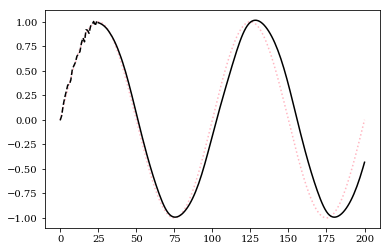

In [16]:
plt.rc('font', family='serif')
plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='lightpink')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='black')
plt.show()

# Kerasによる実装

In [17]:
from keras.optimizers import Adam
from keras.layers import Dense, Activation
from keras.layers.recurrent import GRU
from keras.models import Sequential
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [18]:
def weight_variable(shape, name=None):
    return np.random.normal(scale=.01, size=shape)

In [19]:
model = Sequential()
model.add(GRU(n_hidden, init=weight_variable,
                   input_shape=(maxlen, n_in)))
model.add(Dense(n_out, init=weight_variable))
model.add(Activation('linear'))

In [20]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [22]:
epochs = 500
batch_size = 10

model.fit(X_train, Y_train, batch_size=batch_size,
         epochs=epochs,
         validation_data=(X_validation, Y_validation),
         callbacks=[early_stopping])

Train on 158 samples, validate on 18 samples
Epoch 1/500
158/158 [==============================] - 1s 4ms/step - loss: 0.5077 - val_loss: 0.4251
Epoch 2/500
158/158 [==============================] - 0s 1ms/step - loss: 0.4876 - val_loss: 0.4006
Epoch 3/500
158/158 [==============================] - 0s 2ms/step - loss: 0.4217 - val_loss: 0.3156
Epoch 4/500
158/158 [==============================] - 0s 2ms/step - loss: 0.2571 - val_loss: 0.1529
Epoch 5/500
158/158 [==============================] - 0s 2ms/step - loss: 0.1610 - val_loss: 0.1216
Epoch 6/500
158/158 [==============================] - 0s 2ms/step - loss: 0.1133 - val_loss: 0.0887
Epoch 7/500
158/158 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0661
Epoch 8/500
158/158 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0506
Epoch 9/500
158/158 [==============================] - 0s 1ms/step - loss: 0.0527 - val_loss: 0.0446
Epoch 10/500
158/158 [========================

In [23]:
truncate = 25
Z = X[:1]

original = [f[i] for i in range(25)]
predicted = [None for i in range(25)]

for i in range(200 - 25 + 1):
    z_ = Z[-1:]
    y_ = model.predict(z_)
    sequence_ = np.concatenate(
    (z_.reshape(25, n_in)[1:], y_),
    axis=0).reshape(1, 25, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

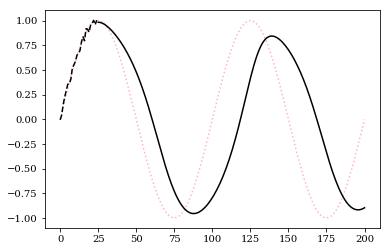

In [24]:
plt.rc('font', family='serif')
plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='lightpink')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='black')
plt.show()